## Imports

In [1]:
import os
import zipfile
from six.moves.urllib.request import urlretrieve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import re
import string
import contractions
from tqdm import tqdm
tqdm.pandas(desc="Progress Bar")

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords       # used for preprocessing
from nltk.stem import WordNetLemmatizer # used for preprocessing
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')

from deep_translator import GoogleTranslator
from langdetect import DetectorFactory, detect
DetectorFactory.seed = 0

import warnings
warnings.filterwarnings('ignore')

In [2]:
ROOT_DIR = Path().resolve().parent

TRAIN_DATA_PATH = ROOT_DIR/"input/train.csv"
TEST_DATA_PATH = ROOT_DIR/"input/test.csv"

## Get Data

Dataset Description

train.csv: A full training dataset with the following attributes:

- `id`: unique id for a news article
- `title`: the title of a news article
- `author`: author of the news article
- `text`: the text of the article; could be incomplete
- `label`: a label that marks the article as potentially unreliable
    - 1: unreliable
    - 0: reliable

In [3]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### random sample

In [5]:
import random

random_idx = random.sample(train_df.index.to_list(), 1)[0]
random_news = train_df.iloc[random_idx]['text']

print(random_news[:len(random_news)//2])

Johnny Depp is back as the swashbuckling Jack Sparrow in the first full trailer for Pirates of the Caribbean: Dead Men Tell No Tales, the fifth installment in the Pirates franchise due out this May. [The film’s synopsis, courtesy of Disney:  Thrust into an   adventure, a     Captain Jack Sparrow finds the winds of   blowing even more strongly when deadly ghost pirates led by his old nemesis, the terrifying Captain Salazar, escape from the Devil’s Triangle, determined to kill every pirate at sea  …     including him. Captain Jack’s only hope of survival lies in seeking out the legendary Trident of Poseid


In [5]:
from langdetect import DetectorFactory, detect_langs, detect
DetectorFactory.seed = 0

In [6]:
detect_langs(train_df.iloc[0]['text']),\
detect(train_df.iloc[0]['text'])

([en:0.9999978458389382], 'en')

In [20]:
# from google_trans_new import google_translator


# translator = google_translator()

In [71]:
temp = train_df.copy()

temp['title'] = temp['title'].progress_apply(lambda x: detect_and_translate(x))

Progress Bar: 100%|██████████████████████████████████████████████████████████████| 20800/20800 [09:35<00:00, 36.16it/s]


In [75]:
temp.loc[47,'title'], temp.loc[5766, 'title'], temp.loc[7423, 'title']

('Serbian media attributed to the Russians "preparation of terrorist attacks" in Montenegro',
 'What to do if your partner moves into your apartment?',
 'Russian President Watches')

In [86]:
temp['text'] = temp['text'].progress_apply(lambda x: detect_and_translate(x))

Progress Bar: 100%|██████████████████████████████████████████████████████████████| 20800/20800 [24:24<00:00, 14.20it/s]


In [91]:
# temp.loc[47,'text'][:10], temp.loc[5766, 'text'], temp.loc[7423, 'text']


## Text Data Statistics

- We have Balanced dataset with almost equal number of `1: unreliable, 0: reliable` news labels.
- We only need `title`, `text` and `label` columns
- 99% of the news articles have less than equal to 4095 words in them
- 99% of the title have less than equal to 23 words in them
- `title` and `text` column has few null values, which will be dropped

In [5]:
# We have Balanced dataset
train_df.label.value_counts()

label
1    10413
0    10387
Name: count, dtype: int64

In [6]:
# Drop all null values
train_df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
# Statistics of news 'text' in the data
train_df["text"].str.split(" ").str.len().describe(percentiles=[0.01, 0.5, 0.75, 0.99])

# 99% of the news articles have less than equal to 4095 words in them

count    20761.000000
mean       774.652762
std        881.659782
min          1.000000
1%           8.000000
50%        566.000000
75%       1071.000000
99%       4094.800000
max      24234.000000
Name: text, dtype: float64

In [8]:
# Statistics of news 'title' in the data
train_df["title"].str.split(" ").str.len().describe(percentiles=[0.01, 0.5, 0.75, 0.99])

# 99% of the title have less than equal to 23 words in them

count    20242.000000
mean        12.433011
std          4.096591
min          1.000000
1%           3.000000
50%         13.000000
75%         15.000000
99%         23.000000
max         72.000000
Name: title, dtype: float64

## Data Cleaning

In [6]:
# from deep_translator import GoogleTranslator
# from langdetect import detect
# DetectorFactory.seed = 0

def detect_and_translate(text):
    try:
        result_lang = detect(text)
        if result_lang == 'en':
            return text 
        else:
            translated_text = GoogleTranslator(source='auto', target='en').translate(text)
            return translated_text
    except:
        return text

In [8]:
stop_word = stopwords.words('english')
le = WordNetLemmatizer()

def text_cleaning(text:str) -> str:
    if pd.isnull(text) or text == '' or text.isspace():
        return "NOT"
    
    # lower-case everything
    text = text.lower().strip()
    
    # translate any non-english text
    text = detect_and_translate(text)
    
    # expand all the short-form words
    text = contractions.fix(text)
    
    # For removing puctuations
    # translator = str.maketrans('', '', string.punctuation)
    
    # remove any special chars
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) # Remove URLs
    text = re.sub(r'\S+@\S+', '', text) # Remove emails
    text = re.sub(r'\b\d{1,3}[-./]?\d{1,3}[-./]?\d{1,4}\b', '', text) # Remove phone numbers
    # text = text.translate(translator) # Remove puctuations
    text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove other non-alphanumeric characters 
    
    # tokenization
    word_tokens = word_tokenize(text)
    
    # remove stop-word and lemmatize
    tokens = [le.lemmatize(w) for w in word_tokens if w not in stop_word] #  and len(w)>3
    
    cleaned_text = " ".join(tokens)
    
    if cleaned_text.isspace() or cleaned_text=='':
        return "NOT"
    return cleaned_text

In [9]:
cols_to_remove = ['id','author']
text_features = ['title', 'text']
target_col = ['label']


def clean_data(df:pd.DataFrame)->pd.DataFrame:
    df = df.drop(cols_to_remove, axis=1)
    
    for col in text_features:
        df.loc[df[col].isnull(), col] = "NOT"
            
    df['title'] = df['title'].progress_apply(lambda x: text_cleaning(x))
    df['text'] = df['text'].progress_apply(lambda x: text_cleaning(x))
    
    
    null_indexs = df[(df.title=='NOT') & (df.text=='NOT')].index
    df = df.drop(index=null_indexs)
    df = df.reset_index(drop=True)    
    
    return df

In [10]:
cleaned_train_df = clean_data(train_df)

Progress Bar: 100%|██████████████████████████████████████████████████████████████| 20800/20800 [25:52<00:00, 13.40it/s]


In [11]:
cleaned_train_df.to_csv(ROOT_DIR/"input/cleaned_train_data.csv", index=False)

## EDA

In [4]:
CLEANED_DATA_PATH = ROOT_DIR/"input/cleaned_train_data.csv"

clean_train_df = pd.read_csv(CLEANED_DATA_PATH)
clean_train_df.head()

,title,text,label
0,house dem aide even see comey letter jason cha...,house dem aide even see comey letter jason cha...,1
1,flynn hillary clinton big woman campus breitbart,ever get feeling life circle roundabout rather...,0
2,truth might get fired,truth might get fired october tension intellig...,1
3,civilian killed single u airstrike identified,video civilian killed single u airstrike ident...,1
4,iranian woman jailed fictional unpublished sto...,print iranian woman sentenced six year prison ...,1


### Word cloud for all words in the dataset

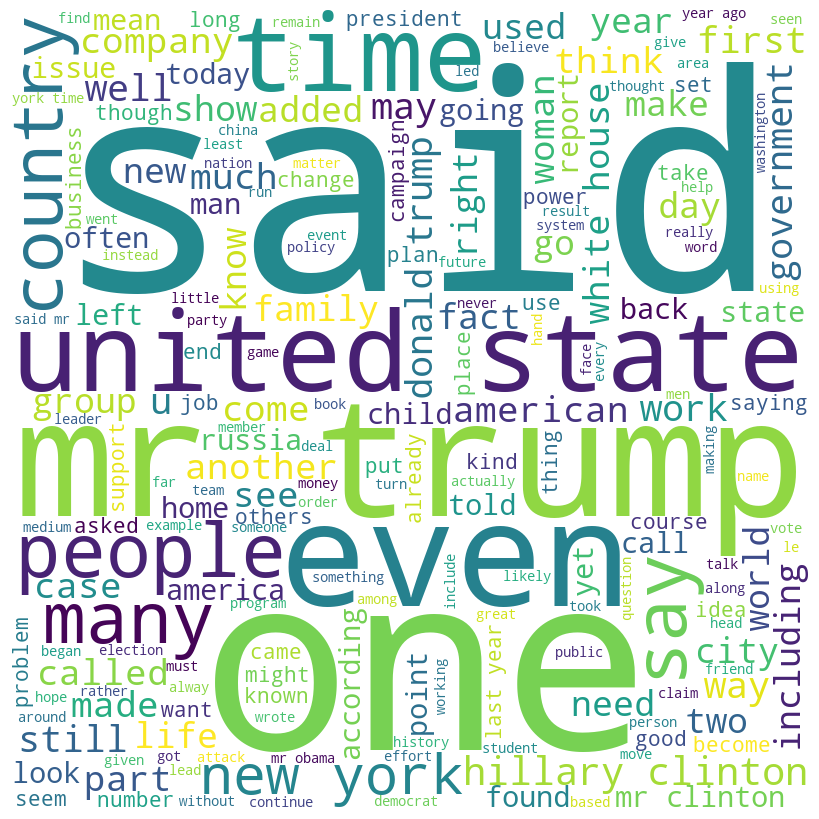

In [9]:
from wordcloud import WordCloud, STOPWORDS
from textwrap import wrap

stopwords = set(STOPWORDS)

news = ' '.join(clean_train_df['text'])

wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=stopwords,
                      min_font_size=10).generate(news)


# plot the wordcloud image
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show();

### Word cloud for Fake label news only

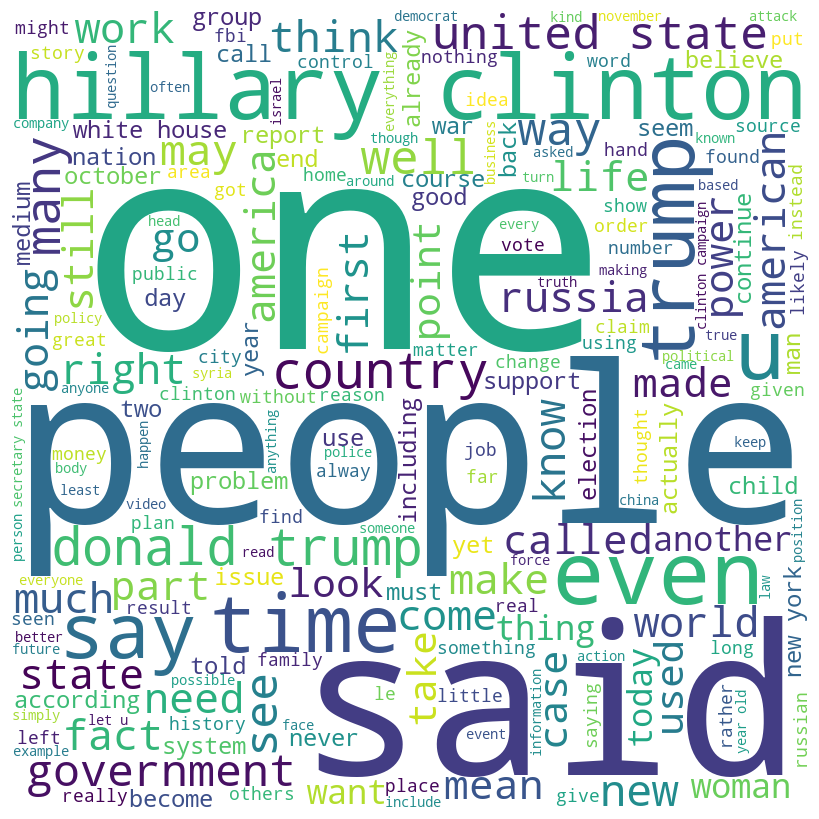

In [10]:
fake_news = ' '.join(clean_train_df[clean_train_df.label==1]['text'])

wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=stopwords,
                      min_font_size=10).generate(fake_news)


# plot the wordcloud image
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show();

### Word cloud for True label news only

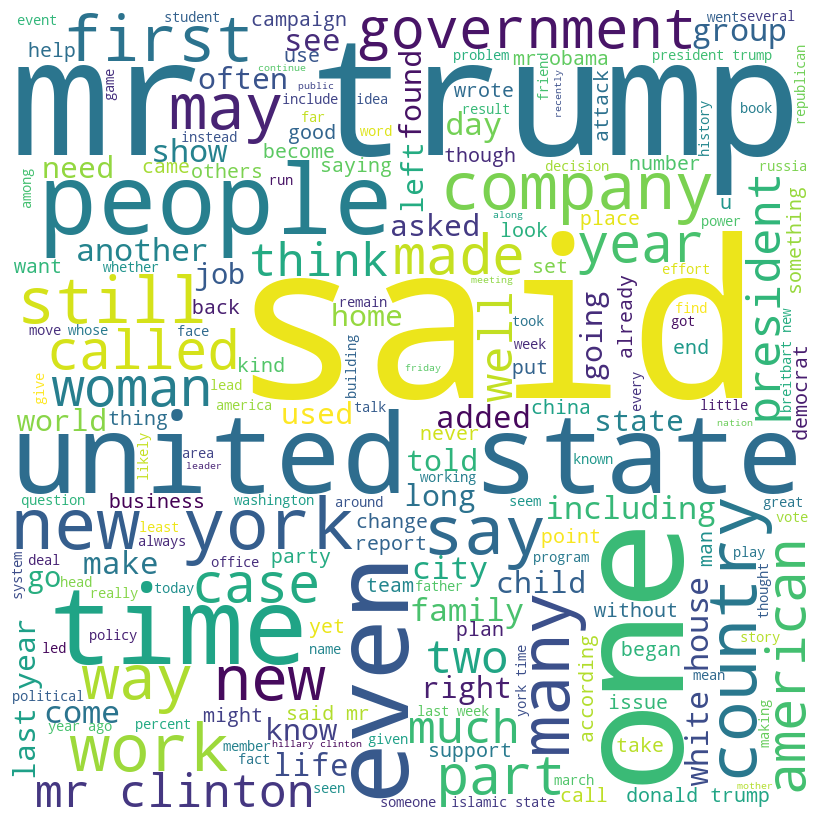

In [11]:
not_fake_news = ' '.join(clean_train_df[clean_train_df.label==0]['text'])

wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=stopwords,
                      min_font_size=10).generate(not_fake_news)


# plot the wordcloud image
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show();

### Most frequent Bigram(Two word combination) of True label

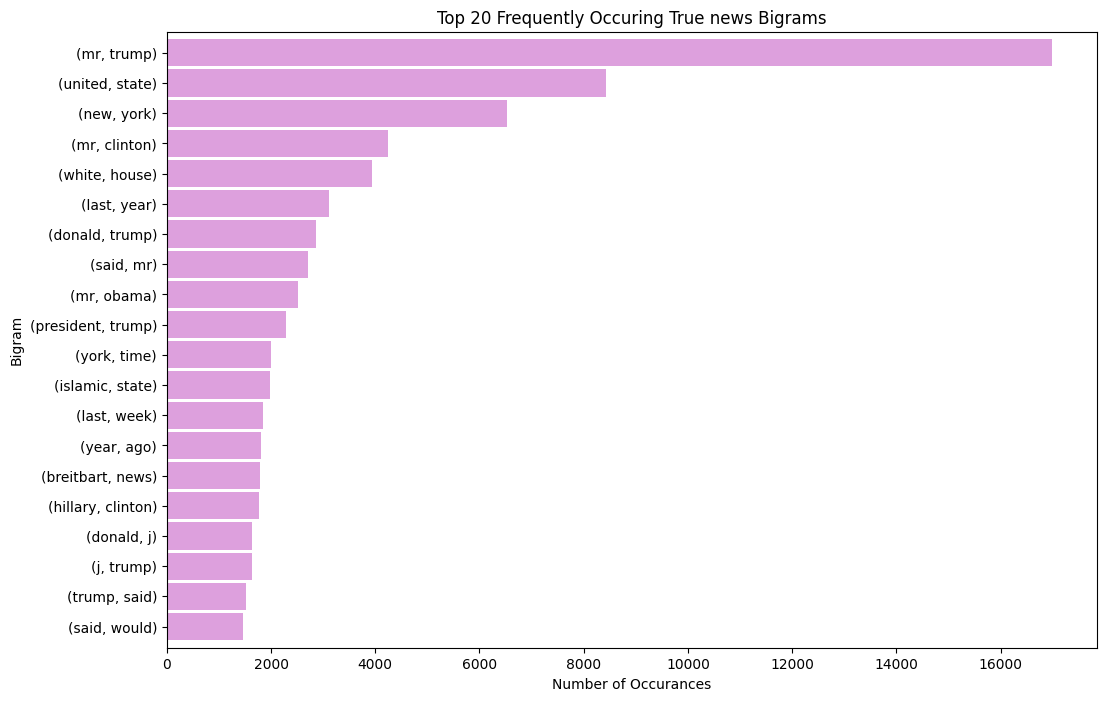

In [12]:
true_bigrams = pd.Series(nltk.ngrams(not_fake_news.split(), 2)).value_counts()[:20]

true_bigrams.sort_values().plot.barh(color='plum', width=.9, figsize=(12, 8))
plt.title('Top 20 Frequently Occuring True news Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')
plt.show();

### Most frequent Bigram(Two word combination) of Fake label

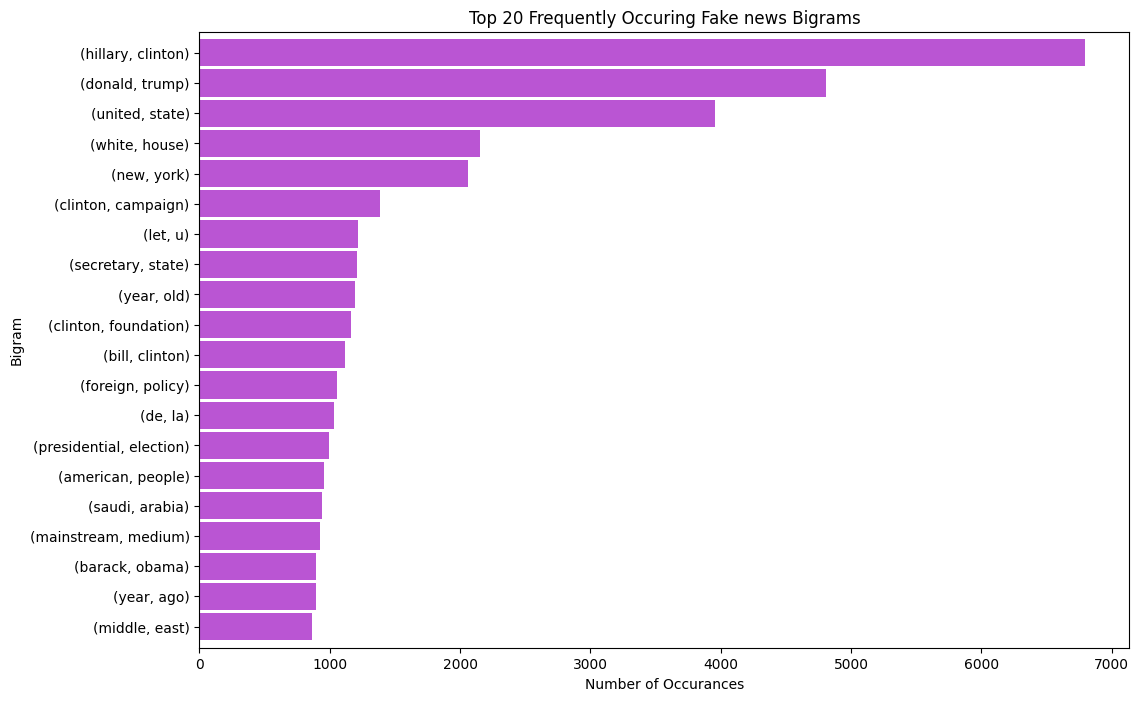

In [13]:
fake_bigrams = pd.Series(nltk.ngrams(fake_news.split(), 2)).value_counts()[:20]

fake_bigrams.sort_values().plot.barh(color='mediumorchid', width=.9, figsize=(12, 8))
plt.title('Top 20 Frequently Occuring Fake news Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')
plt.show();

### Most frequent Trigram(Three word combination) of True label

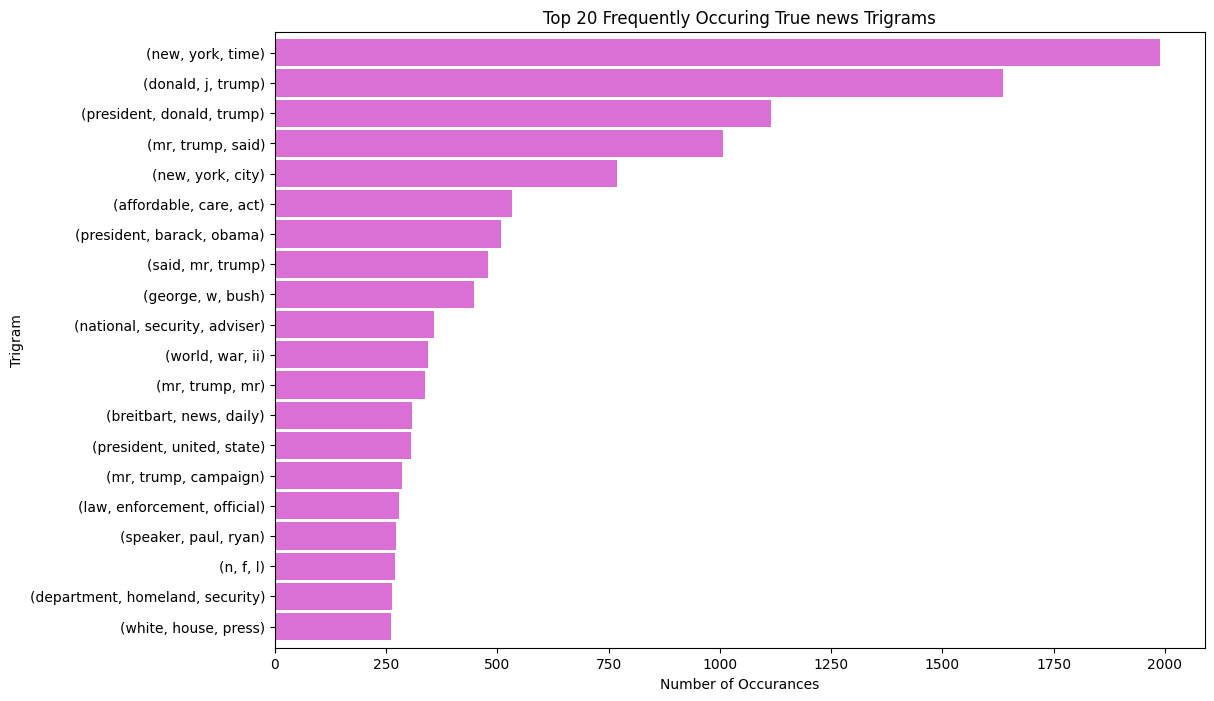

In [14]:
true_trigrams = pd.Series(nltk.ngrams(not_fake_news.split(), 3)).value_counts()[:20]

true_trigrams.sort_values().plot.barh(color='orchid', width=.9, figsize=(12, 8))
plt.title('Top 20 Frequently Occuring True news Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Number of Occurances')
plt.show();

### Most frequent Trigram(Three word combination) of Fake label

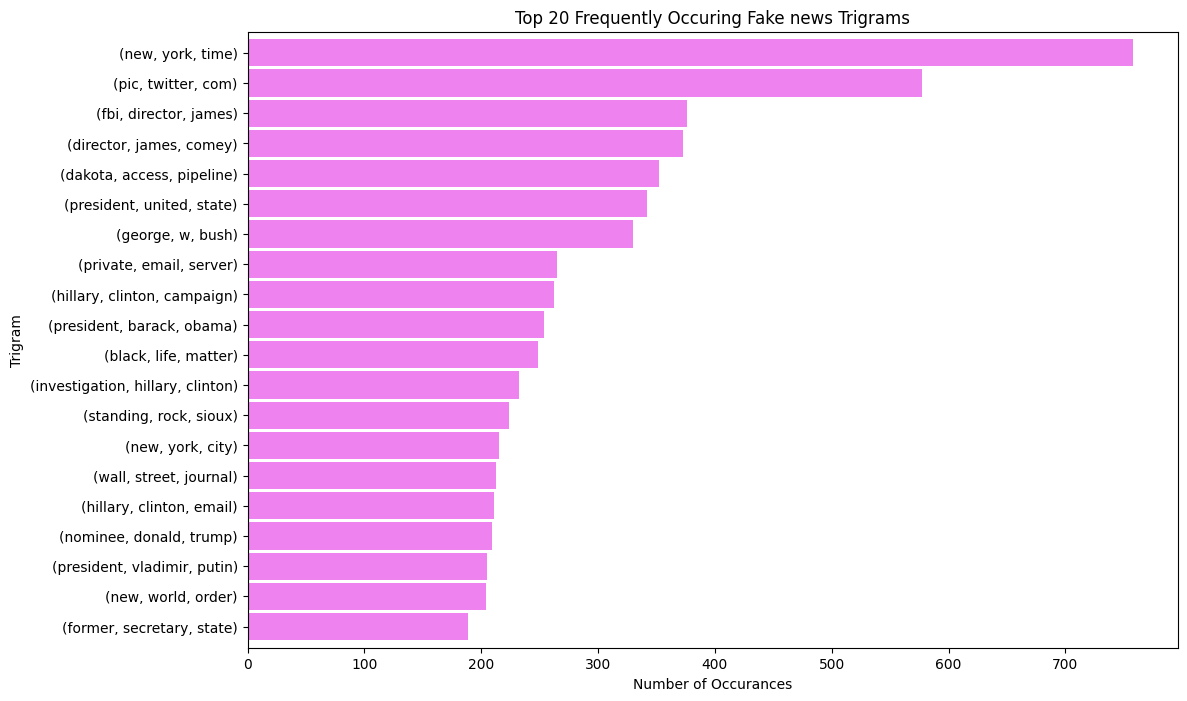

In [15]:
fake_trigrams = pd.Series(nltk.ngrams(fake_news.split(), 3)).value_counts()[:20]

fake_trigrams.sort_values().plot.barh(color='violet', width=.9, figsize=(12, 8))
plt.title('Top 20 Frequently Occuring Fake news Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Number of Occurances')
plt.show();

## Data Preparation

- Seperate training text and labels
- Tokenization
- Text sequence generation
- Pad the text sequence data

In [12]:
CLEANED_DATA_PATH = ROOT_DIR/"input/cleaned_train_data.csv"

clean_train_df = pd.read_csv(CLEANED_DATA_PATH)
clean_train_df.head()

,title,text,label
0,house dem aide even see comey letter jason cha...,house dem aide even see comey letter jason cha...,1
1,flynn hillary clinton big woman campus breitbart,ever get feeling life circle roundabout rather...,0
2,truth might get fired,truth might get fired october tension intellig...,1
3,civilian killed single u airstrike identified,video civilian killed single u airstrike ident...,1
4,iranian woman jailed fictional unpublished sto...,print iranian woman sentenced six year prison ...,1


In [14]:
def aggregate(a,b):
    if a == 'NOT':
        a = ''
    if b == 'NOT':
        b = ''
    text = ' '.join([a,b]).strip()
    return text


def prepare_data(df:pd.DataFrame):
    """
    Return (X, y) text and labels from cleaned data
    """
    df['news'] = df.apply(lambda df: aggregate(df['title'], df['text']), 
                                               axis=1)
    
    X, y = df.news, df.label
    return X, y

In [15]:
X_train, y_train = prepare_data(clean_train_df)

X_train.shape, y_train.shape

((20799,), (20799,))

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Tokenization

In [17]:
vocab_size = 100000+1

tokenizer = Tokenizer(num_words=vocab_size-1, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)

In [18]:
len(tokenizer.word_index)

125685

In [19]:
import itertools

word_count = tokenizer.word_counts # count of all words in corpus
dict(itertools.islice(dict(word_count).items(), 10))

{'house': 13168,
 'dem': 188,
 'aide': 1892,
 'even': 19153,
 'see': 11658,
 'comey': 3829,
 'letter': 2956,
 'jason': 589,
 'chaffetz': 183,
 'tweeted': 586}

In [20]:
n_vocab = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {n_vocab}")

print("\nWords at the top")
print(dict(list(tokenizer.word_index.items())[:10]))
print("\nWords at the bottom")
print(dict(list(tokenizer.word_index.items())[-10:]))

Vocabulary size: 125686

Words at the top
{'<OOV>': 1, 'said': 2, 'mr': 3, 'trump': 4, 'would': 5, 'one': 6, 'state': 7, 'time': 8, 'new': 9, 'people': 10}

Words at the bottom
{'setyono': 125676, 'otso': 125677, 'ichwanul': 125678, 'nurul': 125679, 'sukri': 125680, 'anshorut': 125681, 'daulah': 125682, 'doggystyle': 125683, 'seedings': 125684, 'gennette': 125685}


In [21]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)

len(X_train_sequences), len(X_train_sequences[0]), len(X_train_sequences[1])

(20799, 443, 373)

### Padding

Here we analyze the `1%` and `99%` percentiles of the sequence lengths. We should use the 99% percentile as our maximum sequence length.

But since we are using glove word embeddings, let's keep `max_seq_len=300` as we w'll using glove pretrained word embedding: `glove.6B.300d.txt`

In [22]:
clean_train_df['news'].str.split(" ").str.len().describe(percentiles=[0.01, 0.5, 0.99])

count    20799.000000
mean       424.060916
std        458.635494
min          1.000000
1%           6.000000
50%        313.000000
99%       2187.000000
max      11992.000000
Name: news, dtype: float64

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
max_seq_len = 300

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_seq_len,
                               padding='post', truncating='post')

In [25]:
X_train_padded.shape

(20799, 300)

### Embeddings

In [26]:
url = 'https://nlp.stanford.edu/data/glove.6B.zip'


def download_glove(url, data_dir):
    """Download a file if not present, and make sure it's the right size."""
    
    os.makedirs(data_dir, exist_ok=True)

    file_path = os.path.join(data_dir, os.path.basename(url))
  
    if not os.path.exists(file_path):
        print('Downloading file...')
        filename, _ = urlretrieve(url, file_path)
    else:
        print("File already exists")
  
    extract_path = os.path.join(data_dir, 'glove')
    os.makedirs(extract_path, exist_ok=True)
    
    if not any(os.scandir(extract_path)):
        print(f"Extracting {os.path.basename(url)}")
        
        with zipfile.ZipFile(file_path, 'r') as zipf:
            zipf.extractall(extract_path)
            
        print(f"File extracted to [../input/glove]")
    else:
        print(f"{os.path.basename(url)} has already been extracted")
    

download_dir = ROOT_DIR/"input"    
download_glove(url, download_dir)

File already exists
glove.6B.zip has already been extracted


In [27]:
embedding_dim = max_seq_len # 300
file_path = ROOT_DIR/f"input/glove/glove.6B.{str(embedding_dim)}d.txt"

word_vec = pd.read_table(file_path, sep=r"\s", header=None, engine='python',
                         encoding='iso-8859-1', on_bad_lines='skip')

word_vec = word_vec.set_index(0)

word_vec.head()

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
the,0.046560,0.213180,-0.007436,-0.458540,-0.035639,0.236430,-0.288360,0.215210,-0.134860,-1.6413,...,-0.013064,-0.296860,-0.079913,0.195000,0.031549,0.285060,-0.087461,0.009061,-0.209890,0.053913
",",-0.255390,-0.257230,0.131690,-0.042688,0.218170,-0.022702,-0.178540,0.107560,0.058936,-1.3854,...,0.075968,-0.014359,-0.073794,0.221760,0.146520,0.566860,0.053307,-0.232900,-0.122260,0.354990
.,-0.125590,0.013630,0.103060,-0.101230,0.098128,0.136270,-0.107210,0.236970,0.328700,-1.6785,...,0.060148,-0.156190,-0.119490,0.234450,0.081367,0.246180,-0.152420,-0.342240,-0.022394,0.136840
of,-0.076947,-0.021211,0.212710,-0.722320,-0.139880,-0.122340,-0.175210,0.121370,-0.070866,-1.5721,...,-0.366730,-0.386030,0.302900,0.015747,0.340360,0.478410,0.068617,0.183510,-0.291830,-0.046533
to,-0.257560,-0.057132,-0.671900,-0.380820,-0.364210,-0.082155,-0.010955,-0.082047,0.460560,-1.8477,...,-0.012806,-0.597070,0.317340,-0.252670,0.543840,0.063007,-0.049795,-0.160430,0.046744,-0.070621


In [28]:
embeddings_index = word_vec.T.to_dict(orient='list')

In [29]:
word_index = tokenizer.word_index

In [30]:
embedding_matrix = np.zeros((len(word_index) + 1, max_seq_len))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = np.asarray(embedding_vector)

In [31]:
embedding_matrix.shape

(125686, 300)

In [36]:
from tensorflow.keras.backend import clear_session

clear_session()

In [37]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=max_seq_len,
                            weights=[embedding_matrix],
                            input_length=max_seq_len,
                            trainable=False)

In [38]:
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(embedding_layer)
model.add(LSTM(max_seq_len))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          37705800  
                                                                 
 lstm (LSTM)                 (None, 300)               721200    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 32)                9632      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 38,436,665
Trainable params: 730,865
Non-t

In [39]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [40]:
history = model.fit(X_train_padded, y_train, 
                    epochs=30, batch_size=256,
                    validation_split=0.2, workers=10)

Epoch 1/30
65/65 [==============================] - 6s 71ms/step - loss: 0.6152 - accuracy: 0.6720 - val_loss: 0.5813 - val_accuracy: 0.7284
Epoch 2/30
65/65 [==============================] - 4s 68ms/step - loss: 0.5656 - accuracy: 0.7283 - val_loss: 0.5322 - val_accuracy: 0.7356
Epoch 3/30
65/65 [==============================] - 5s 75ms/step - loss: 0.6048 - accuracy: 0.6773 - val_loss: 0.6094 - val_accuracy: 0.6764
Epoch 4/30
65/65 [==============================] - 5s 71ms/step - loss: 0.7173 - accuracy: 0.6022 - val_loss: 0.6646 - val_accuracy: 0.6349
Epoch 5/30
65/65 [==============================] - 5s 71ms/step - loss: 0.6527 - accuracy: 0.6238 - val_loss: 0.6495 - val_accuracy: 0.6507
Epoch 6/30
65/65 [==============================] - 5s 71ms/step - loss: 0.6181 - accuracy: 0.6682 - val_loss: 0.5281 - val_accuracy: 0.7332
Epoch 7/30
65/65 [==============================] - 5s 70ms/step - loss: 0.4979 - accuracy: 0.7652 - val_loss: 0.3381 - val_accuracy: 0.8579
Epoch 8/30
65

In [41]:
test_df = pd.read_csv(TEST_DATA_PATH)
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [42]:
cols_to_remove = ['id','author']
text_features = ['title', 'text']
target_col = ['label']


def temp_clean_data(df:pd.DataFrame)->pd.DataFrame:
    df = df.drop(cols_to_remove, axis=1)
    
    for col in text_features:
        df.loc[df[col].isnull(), col] = "NOT"
            
    df['title'] = df['title'].progress_apply(lambda x: text_cleaning(x))
    df['text'] = df['text'].progress_apply(lambda x: text_cleaning(x))
    
    
    #null_indexs = df[(df.title=='NOT') & (df.text=='NOT')].index
    #df = df.drop(index=null_indexs)
    df = df.reset_index(drop=True)    
    
    return df

In [43]:
clean_test_df = temp_clean_data(test_df)
clean_test_df.head()

Progress Bar: 100%|████████████████████████████████████████████████████████████████| 5200/5200 [06:47<00:00, 12.75it/s]


,title,text
0,specter trump loosens tongue purse string sili...,palo alto calif year scorning political proces...
1,russian warship ready strike terrorist near al...,russian warship ready strike terrorist near al...
2,nodapl native american leader vow stay winter ...,video nodapl native american leader vow stay w...
3,tim tebow attempt another comeback time baseba...,first succeed try different sport tim tebow he...
4,keiser report meme war e,min ago view comment like first time history f...


In [44]:
def temp(a,b):
    # if a == 'NOT':
    #     a = ''
    # if b == 'NOT':
    #     b = ''
    text = ' '.join([a,b]).strip()
    return text


def prepare_test_data(df:pd.DataFrame):
    """
    Return (X, y) text and labels from cleaned data
    """
    df['news'] = df.apply(lambda df: temp(df['title'], df['text']), 
                                               axis=1)
    
    X = df.news
    return X

In [45]:
X_test = prepare_test_data(clean_test_df)

In [46]:
X_test.shape

(5200,)

In [47]:
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [48]:
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_seq_len,
                              padding='post',
                              truncating='post')

In [49]:
y_pred = model.predict(X_test_padded) 

163/163 [==============================] - 4s 21ms/step


In [50]:
np.round(y_pred)

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [51]:
len(np.round(y_pred.reshape((len(y_pred)))))

5200

In [52]:
submit = pd.DataFrame({'id':test_df.id, 'label':np.round(y_pred.reshape((len(y_pred))))})

In [53]:
submit['label'] = submit.label.astype('int')

In [54]:
submit

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
...,...,...
5195,25995,0
5196,25996,0
5197,25997,0
5198,25998,1


In [55]:
submit.to_csv('submit_new.csv', index=False)